In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.models import model_from_json

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

## Load data

In [2]:
X_raw = np.load("data/images.npy")
y = np.load("data/labels.npy")
y = [val[0] for val in y]

In [3]:
print(f"Images are {X_raw[0].shape[0]} x {X_raw[0].shape[1]} pixels with {X_raw[0].shape[2]} color channels")

Images are 480 x 640 pixels with 3 color channels


In [4]:
# Train Test split

X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(X_raw, y, test_size=0.1, random_state=123)

In [5]:
# prepare train images for the VGG model
X_trainval = []
for i in range(len(X_trainval_raw)):
    X_trainval.append(cv2.resize(X_trainval_raw[i],(224,224),3))
    X_trainval[i] = preprocess_input(X_trainval[i])

# prepare test images for the VGG model
X_test = []
for i in range(len(X_test_raw)):
    X_test.append(cv2.resize(X_test_raw[i],(224,224),3))
    X_test[i] = preprocess_input(X_test[i])

In [6]:
print(f"Processed images are {X_test[0].shape[0]} x {X_test[0].shape[1]} pixels with {X_test[0].shape[2]} color channels")

Processed images are 224 x 224 pixels with 3 color channels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Processed Image')

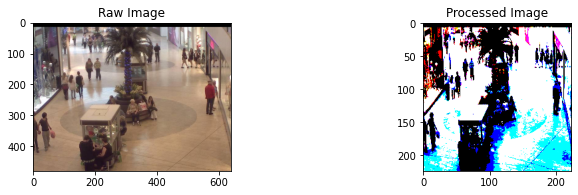

In [7]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_test_raw[0])
ax1.set_title('Raw Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_test[0])
ax2.set_title('Processed Image')

In [8]:
# validation split

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

In [9]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

# VGG16 importing and fine tuning

## Model VGG16 fine tuning (on kaggle, don't run here!)

In [ ]:
# Import VGG16
vgg16_model = VGG16(weights='imagenet', 
                    input_shape=(112*2,112*2,3) ,include_top=False, pooling=False)

# Final part of network
x = vgg16_model.output  # Output is of the pooling layer
x = Dropout(0.3)(x)
x = Flatten()(x)
#x = Dense(128, activation='relu')(x)  # Fully-connected layer because ends with maxpooling
predictions = Dense(1)(x)  # New output layer / regressor

# Create final model
vgg16_model_total = Model(inputs=vgg16_model.input, outputs=predictions)
vgg16_model_total.summary()

In [ ]:
for l in vgg16_model_total.layers[:-3]:
    l.trainable = False # train only final part of network

for l in vgg16_model_total.layers:
    print(l.name, l.output_shape)

In [ ]:
# Compile the model
vgg16_model_total.compile(loss="mean_squared_error",
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                          metrics=['mae'])

In [ ]:
history = vgg16_model_total.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=32)


In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

In [ ]:
# serialize model to JSON
model_save_json = vgg16_model_total.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_save_json)

# serialize weights to HDF5
vgg16_model_total.save_weights("vgg16_model_total.h5")
print("Saved model to disk")

## Load model trained on Kaggle

LOAD AND EVALUATE MODEL 5: OUTPUT WITH DROPOUT 224x224
Loaded model from disk
Trainable layers added to VGG16 output:
dropout (None, 7, 7, 512)
flatten (None, 25088)
dense (None, 1)
On test set we have a mean absolute error of 2.53 people


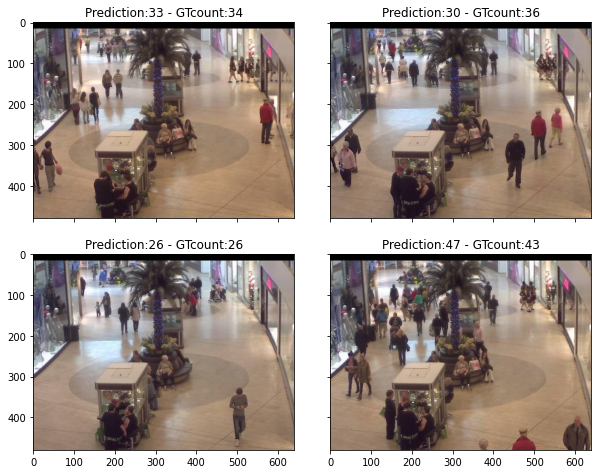

In [10]:
# Model 1: Dropout

print("LOAD AND EVALUATE MODEL 5: OUTPUT WITH DROPOUT 224x224")

json_file = open('trained_models/vgg16_fine_tuning_224_Dropout/model224.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("trained_models/vgg16_fine_tuning_224_Dropout/vgg16_model_total224.h5")
print("Loaded model from disk")

print("Trainable layers added to VGG16 output:")
for l in loaded_model.layers[19:]:
    print(l.name, l.output_shape)

loaded_model.compile(loss='mean_squared_error', 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics=['mae'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)

print(f'On test set we have a mean absolute error of {round(score[1],2)} people')

predictions = loaded_model.predict(X_test)

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5)

for i in range(0,4):
    grid[i].set_title('Prediction:'+ str(int(np.round(predictions[i],1))) +' - GTcount:'+str(y_test[i]))
    grid[i].imshow(X_test_raw[i])

LOAD AND EVALUATE MODEL 6: DEEP OUTPUT WITH DROPOUT 224x224
Loaded model from disk
Trainable layers added to VGG16 output:
dropout (None, 7, 7, 512)
dense (None, 7, 7, 256)
dropout_1 (None, 7, 7, 256)
dense_1 (None, 7, 7, 128)
dropout_2 (None, 7, 7, 128)
dense_2 (None, 7, 7, 64)
flatten (None, 3136)
dense_3 (None, 1)
On test set we have a mean absolute error of 2.47 people


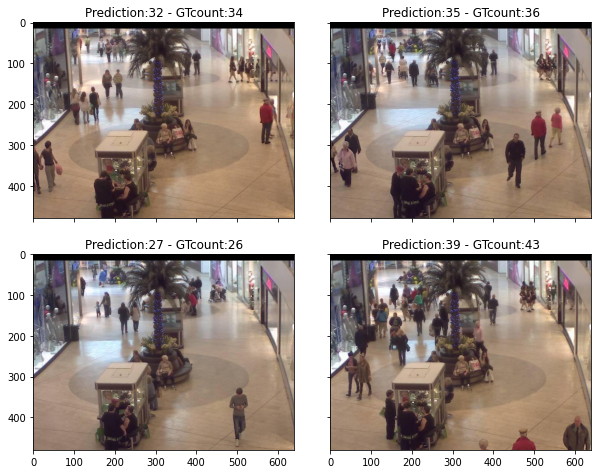

In [11]:
# Model 6: Deep and No dropout

print("LOAD AND EVALUATE MODEL 6: DEEP OUTPUT WITH DROPOUT 224x224")

json_file = open('trained_models/vgg16_fine_tuning_224_Deep_Dropout/model_deepdropout224.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("trained_models/vgg16_fine_tuning_224_Deep_Dropout/vgg16_model_deepdropout224.h5")
print("Loaded model from disk")

print("Trainable layers added to VGG16 output:")
for l in loaded_model.layers[19:]:
    print(l.name, l.output_shape)

loaded_model.compile(loss='mean_squared_error', 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics=['mae'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)

print(f'On test set we have a mean absolute error of {round(score[1],2)} people')

predictions = loaded_model.predict(X_test)

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5)

for i in range(0,4):
    grid[i].set_title('Prediction:'+ str(int(np.round(predictions[i],1))) +' - GTcount:'+str(y_test[i]))
    grid[i].imshow(X_test_raw[i])